#TEXT CLASSIFICATION WITH THE TORCHTEXT LIBRARY
In this tutorial, we will show how to use the torchtext library to build the dataset for the text classification analysis. Users will have the flexibility to

Access to the raw data as an iterator
Build data processing pipeline to convert the raw text strings into torch.Tensor that can be used to train the model
Shuffle and iterate the data with torch.utils.data.DataLoader
Access to the raw dataset iterators
The torchtext library provides a few raw dataset iterators, which yield the raw text strings. For example, the AG_NEWS dataset iterators yield the raw data as a tuple of label and text.

To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data.


Orginal Source
https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [1]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 1.3 MB/s 
     |████████████████████████████████| 138 kB 7.8 MB/s 
     |████████████████████████████████| 127 kB 43.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import torch
from torchtext.datasets import AG_NEWS
train_iter = iter(AG_NEWS(split='train'))

In [3]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [4]:
next(train_iter)

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [5]:
next(train_iter)

(3,
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")

#Prepare data processing pipelines
We have revisited the very basic components of the torchtext library, including vocab, word vectors, tokenizer. Those are the basic data processing building blocks for raw text string.

Here is an example for typical NLP data processing with tokenizer and vocabulary. The first step is to build a vocabulary with the raw training dataset. Here we use built in factory function build_vocab_from_iterator which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the vocabulary.

In [9]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

train_iter

The vocabulary block converts a list of tokens into integers.

In [15]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.

In [16]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers. For example,

In [17]:
text_pipeline('here is the an example')

[475, 21, 2, 30, 5297]

In [18]:
label_pipeline('10')

9

#Generate data batch and iterator
torch.utils.data.DataLoader is recommended for PyTorch users (a tutorial is here). It works with a map-style dataset that implements the getitem() and len() protocols, and represents a map from indices/keys to data samples. It also works with an iterable dataset with the shuffle argument of False.

Before sending to the model, collate_fn function works on a batch of samples generated from DataLoader. The input to collate_fn is a batch of data with the batch size in DataLoader, and collate_fn processes them according to the data processing pipelines declared previously. Pay attention here and make sure that collate_fn is declared as a top level def. This ensures that the function is available in each worker.

In this example, the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of nn.EmbeddingBag. The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of individual text entries.

In [19]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]

    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

# Define the model
The model is composed of the nn.EmbeddingBag layer plus a linear layer for the classification purpose. nn.EmbeddingBag with the default mode of “mean” computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, nn.EmbeddingBag module requires no padding here since the text lengths are saved in offsets.

Additionally, since nn.EmbeddingBag accumulates the average across the embeddings on the fly, nn.EmbeddingBag can enhance the performance and memory efficiency to process a sequence of tensors.



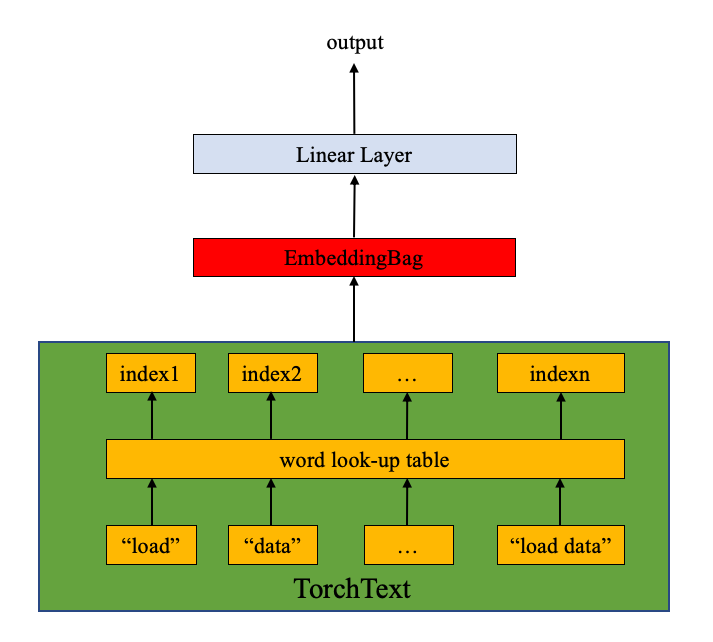

In [20]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)